<a href="https://colab.research.google.com/github/head1ton/ML_Analysis/blob/master/Insightful_EDA_%2B_modeling_LGBM_hyperopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

미국 4대 도시의 교차로에서 정지 거리 및 대기 시간을 측정하여 혼잡을 예측.

    * 애틀란타, 보스턴, 시카고, 필라델피아

* 분석 시 중요한 사항
    * 특성의 데이터 타입은 무엇인지.
    * 결측값이 있는지?
    * 각 특성에 고유한 값이 얼마나 되는지
    * 전체 데이터 세트의 Shape
    * 각 특성의 엔트로피

    
    * 각 열에 어떤 분포가 있는지.
    * 가장 일반적인 도시는 어느 도시인지.
    * 정류장, 시간, 거리의 분포는 어떤지.
    * 기간은 얼마나 되는지
    * 지역의 분포는 어떤지.

In [0]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook', palette='deep')

import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode

# import cufflinks
# import cufflinks as cf
import plotly.figure_factory as ff

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

In [6]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

./test.csv
./train.csv
./.config/active_config
./.config/.last_update_check.json
./.config/.last_survey_prompt.yaml
./.config/config_sentinel
./.config/gce
./.config/.metricsUUID
./.config/logs/2020.01.30/17.25.30.614837.log
./.config/logs/2020.01.30/17.25.12.057369.log
./.config/logs/2020.01.30/17.24.58.944263.log
./.config/logs/2020.01.30/17.24.41.504215.log
./.config/logs/2020.01.30/17.25.16.036944.log
./.config/logs/2020.01.30/17.25.30.131140.log
./.config/configurations/config_default
./sample_data/anscombe.json
./sample_data/README.md
./sample_data/mnist_test.csv
./sample_data/mnist_train_small.csv
./sample_data/california_housing_train.csv
./sample_data/california_housing_test.csv


In [0]:
# importing datasets
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

## 아래 Util Function 데이터 확인

In [10]:
s1 = pd.DataFrame(df_train.dtypes, columns=['dtypes'])
s1

,dtypes
RowId,int64
IntersectionId,int64
Latitude,float64
Longitude,float64
EntryStreetName,object
ExitStreetName,object
EntryHeading,object
ExitHeading,object
Hour,int64
Weekend,int64


In [11]:
s1 = s1.reset_index()
s1

,index,dtypes
0,RowId,int64
1,IntersectionId,int64
2,Latitude,float64
3,Longitude,float64
4,EntryStreetName,object
5,ExitStreetName,object
6,EntryHeading,object
7,ExitHeading,object
8,Hour,int64
9,Weekend,int64


In [12]:
s1['Name'] = s1['index']
s1

,index,dtypes,Name
0,RowId,int64,RowId
1,IntersectionId,int64,IntersectionId
2,Latitude,float64,Latitude
3,Longitude,float64,Longitude
4,EntryStreetName,object,EntryStreetName
5,ExitStreetName,object,ExitStreetName
6,EntryHeading,object,EntryHeading
7,ExitHeading,object,ExitHeading
8,Hour,int64,Hour
9,Weekend,int64,Weekend


In [13]:
s1 = s1[['Name', 'dtypes']]
s1

,Name,dtypes
0,RowId,int64
1,IntersectionId,int64
2,Latitude,float64
3,Longitude,float64
4,EntryStreetName,object
5,ExitStreetName,object
6,EntryHeading,object
7,ExitHeading,object
8,Hour,int64
9,Weekend,int64


In [15]:
df_train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,6,Marietta Boulevard Northwest_NW_Marietta Boulevard Northwest_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,6,Marietta Boulevard Northwest_SE_Marietta Boulevard Northwest_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,6,Marietta Boulevard Northwest_NW_Marietta Boulevard Northwest_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,6,Marietta Boulevard Northwest_SE_Marietta Boulevard Northwest_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,6,Marietta Boulevard Northwest_NW_Marietta Boulevard Northwest_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta


In [14]:
s1['Missing'] = df_train.isnull().sum().values
s1['Uniques'] = df_train.nunique().values
s1['First Value'] = df_train.loc[0].values
s1['Second Value'] = df_train.loc[1].values
s1['Third Value'] = df_train.loc[2].values
s1

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,RowId,int64,0,856387,1921357,1921358,1921359
1,IntersectionId,int64,0,2559,0,0,0
2,Latitude,float64,0,4799,33.7917,33.7917,33.7917
3,Longitude,float64,0,4804,-84.43,-84.43,-84.43
4,EntryStreetName,object,8148,1723,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest
5,ExitStreetName,object,6287,1703,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest
6,EntryHeading,object,0,8,NW,SE,NW
7,ExitHeading,object,0,8,NW,SE,NW
8,Hour,int64,0,24,0,0,1
9,Weekend,int64,0,2,0,0,0


In [17]:
s1['Name'].value_counts().index

Index(['Latitude', 'Weekend', 'Month', 'TimeFromFirstStop_p40',
       'DistanceToFirstStop_p60', 'TotalTimeStopped_p40',
       'DistanceToFirstStop_p80', 'Longitude', 'DistanceToFirstStop_p40',
       'Path', 'Hour', 'EntryStreetName', 'City', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p20',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p50', 'ExitStreetName',
       'TotalTimeStopped_p60', 'ExitHeading', 'TotalTimeStopped_p80',
       'DistanceToFirstStop_p20', 'IntersectionId', 'EntryHeading', 'RowId',
       'TotalTimeStopped_p20', 'TotalTimeStopped_p50'],
      dtype='object')

# Util Functions

In [0]:
# Util functions
def resumetable(df):
    print(f"Dataset Share: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)
        # 엔트로피 : https://datascienceschool.net/view-notebook/d3ecf5cc7027441c8509c0cae7fea088/
        # 엔트로피 요약 : 확률 또는 확률 밀도가 특정값에 몰려있으면 엔트로피가 작다고 하고 반대로 여러가지 값에 골고루 퍼져 있다면 엔트로피가 크다고 한다
    
    return summary

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
# Summary of the data
resumetable(df_train)

Dataset Share: (856387, 28)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,RowId,int64,0,856387,1921357,1921358,1921359,19.71
1,IntersectionId,int64,0,2559,0,0,0,10.63
2,Latitude,float64,0,4799,33.7917,33.7917,33.7917,11.51
3,Longitude,float64,0,4804,-84.43,-84.43,-84.43,11.51
4,EntryStreetName,object,8148,1723,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest,9.04
5,ExitStreetName,object,6287,1703,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest,9.02
6,EntryHeading,object,0,8,NW,SE,NW,2.84
7,ExitHeading,object,0,8,NW,SE,NW,2.84
8,Hour,int64,0,24,0,0,1,4.50
9,Weekend,int64,0,2,0,0,0,0.85


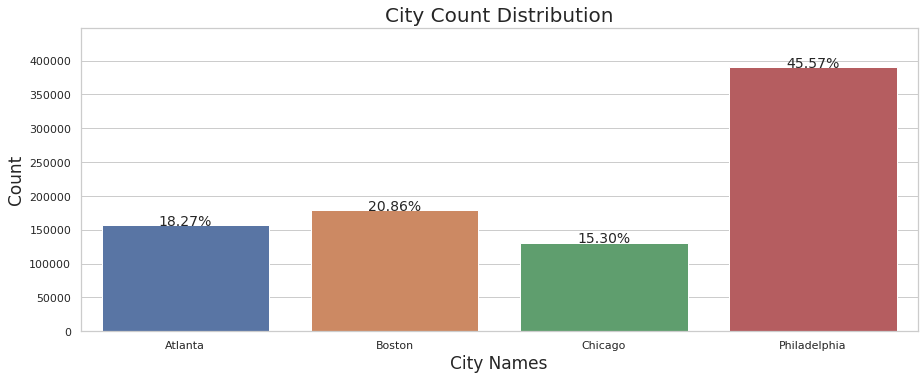

In [24]:
# City's
total = len(df_train)
plt.figure(figsize=(15, 19))

plt.subplot(311)
g = sns.countplot(x="City", data=df_train)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count", fontsize=17)
g.set_xlabel("City Names", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x() + p.get_width() / 2.,
           height + 3,
           '{:1.2f}%'.format(height / total*100),
           ha = "center", fontsize=14)
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

* 전체의 45% 이상이 필라델피아가 차지함을 알 수 있음.

In [26]:
df_train.columns

Index(['RowId', 'IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Path', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'City'],
      dtype='object')

In [27]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
319851,2241208,1162,42.353795,-71.139060,North Beacon Street,Everett Street,W,N,7,0,7,North Beacon Street_W_Everett Street_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Boston
533193,2454550,316,39.960816,-75.232899,South 56th Street,South 56th Street,N,N,22,0,10,South 56th Street_N_South 56th Street_N,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,14.5,Philadelphia
187563,2108920,204,42.322814,-71.100585,Centre Street,Lamartine Street,W,SW,9,0,7,Centre Street_W_Lamartine Street_SW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Boston
351367,2272724,365,41.969019,-87.659673,West Lawrence Avenue,West Lawrence Avenue,E,E,8,0,8,West Lawrence Avenue_E_West Lawrence Avenue_E,0.0,15.0,15.0,19.0,32.0,0.0,25.0,25.0,27.0,41.0,0.0,61.9,61.9,64.4,72.3,Chicago
141846,2063203,462,33.778824,-84.409751,Marietta Street Northwest,Howell Mill Road Northwest,NW,NW,23,0,11,Marietta Street Northwest_NW_Howell Mill Road Northwest_NW,0.0,0.0,18.0,24.0,74.0,0.0,0.0,33.0,52.0,102.0,0.0,0.0,84.0,121.8,268.8,Atlanta


In [25]:
# Data Features
tmp_hour = df_train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()
tmp_hour[:10]

,City,Hour,RowId
0,Atlanta,0,6340
1,Atlanta,1,5544
2,Atlanta,2,4542
3,Atlanta,3,3791
4,Atlanta,4,2890
5,Atlanta,5,3073
6,Atlanta,6,4303
7,Atlanta,7,5776
8,Atlanta,8,6651
9,Atlanta,9,7162


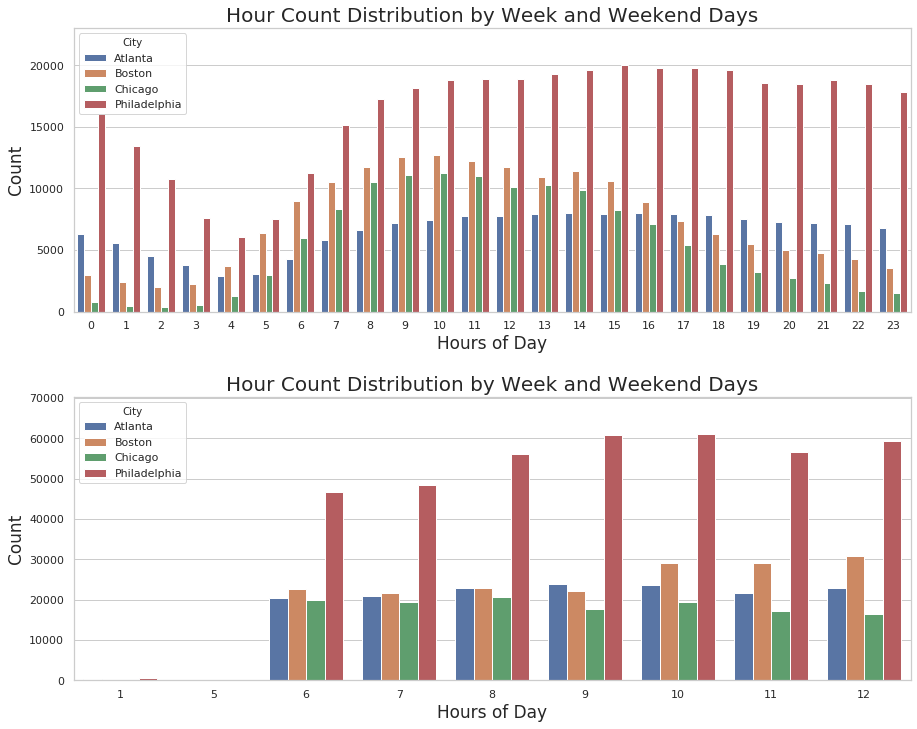

In [30]:
plt.figure(figsize=(15, 12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=df_train, hue="City", dodge=True)
g.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g.set_ylabel("Count", fontsize=17)
g.set_xlabel("Hours of Day", fontsize=17)
sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="Month", data=df_train, hue="City", dodge=True)
g1.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g1.set_ylabel("Count", fontsize=17)
g1.set_xlabel("Hours of Day", fontsize=17)
sizes = []

for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

In [36]:
# Entry Heading and Exit Heading
tmp = round(((df_train.groupby(['EntryHeading'])['RowId'].nunique() / total) * 100)).reset_index()
tmp

,EntryHeading,RowId
0,E,20.0
1,N,16.0
2,NE,7.0
3,NW,7.0
4,S,16.0
5,SE,7.0
6,SW,7.0
7,W,20.0


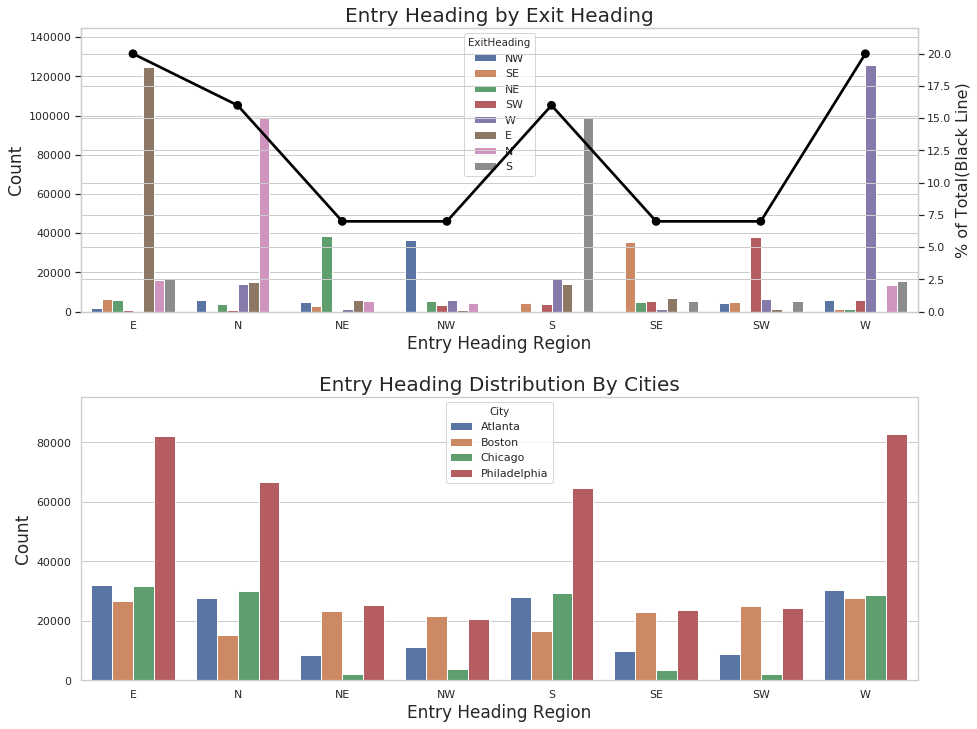

In [41]:
plt.figure(figsize=(15, 12))

plt.subplot(211)
g = sns.countplot(x = "EntryHeading", 
                  data = df_train,
                  order = list(tmp['EntryHeading'].values),
                  hue = 'ExitHeading',
                  dodge = True)
g.set_title("Entry Heading by Exit Heading", fontsize=20)
g.set_ylabel("Count", fontsize=17)
g.set_xlabel("Entry Heading Region", fontsize=17)
gt = g.twinx()
gt = sns.pointplot(x = "EntryHeading", 
                   y="RowId", 
                   data=tmp, 
                   order=list(tmp['EntryHeading'].values),
                   color='black', legend=False)
gt.set_ylim(0, tmp['RowId'].max()*1.1)
gt.set_ylabel("% of Total(Black Line)", fontsize=16)
sizes = []

for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="EntryHeading", order=list(tmp['EntryHeading'].values), 
                   data=df_train, hue='City')
g1.set_title("Entry Heading Distribution By Cities", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Entry Heading Region", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

In [42]:
df_train.IntersectionId.value_counts()[:10]

84     3048
112    2771
345    2652
331    2567
158    2454
889    2416
119    2391
72     2284
86     2211
139    2157
Name: IntersectionId, dtype: int64

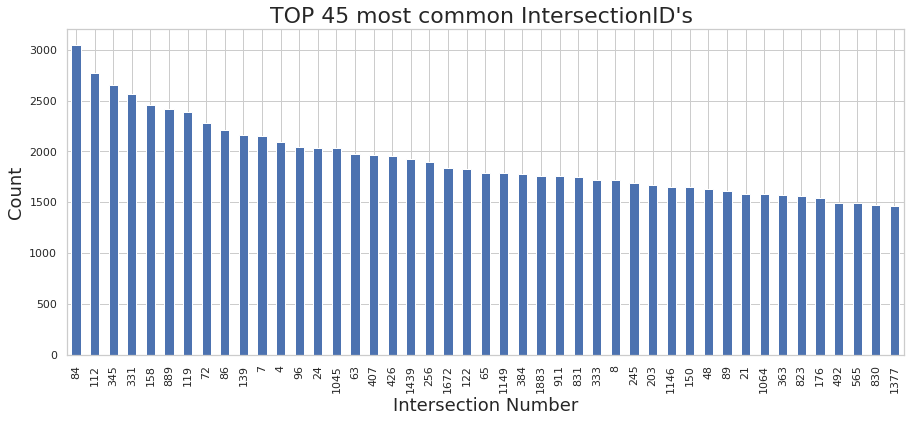

In [43]:
# IntersectionID
plt.figure(figsize=(15,6))
df_train.IntersectionId.value_counts()[:45].plot(kind='bar')
plt.xlabel("Intersection Number", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("TOP 45 most common IntersectionID's ", fontsize=22)

plt.show()

In [44]:
df_train.groupby(['IntersectionId', 'EntryHeading', 'ExitHeading'])['RowId'].count().reset_index().head()

,IntersectionId,EntryHeading,ExitHeading,RowId
0,0,E,E,128
1,0,E,N,23
2,0,E,NW,1
3,0,E,SW,3
4,0,N,E,34


# Exploring numerical features
    * TotalTimeStopped_p20
    * TotalTimeStopped_p50
    * TotalTimeStopped_p80
    * DistanceToFirstStop_p20
    * DistanceToFirstStop_p50
    * DistanceToFirstStop_p80

    and TimeFromFirstStop

In [0]:
t_stopped = ['TotalTimeStopped_p20',
             'TotalTimeStopped_p50',
             'TotalTimeStopped_p80']
t_first_stopped = ['TimeFromFirstStop_p20',
                   'TimeFromFirstStop_p50',
                   'TimeFromFirstStop_p80']
d_first_stopped = ['DistanceToFirstStop_p20',
                   'DistanceToFirstStop_p50',
                   'DistanceToFirstStop_p80']

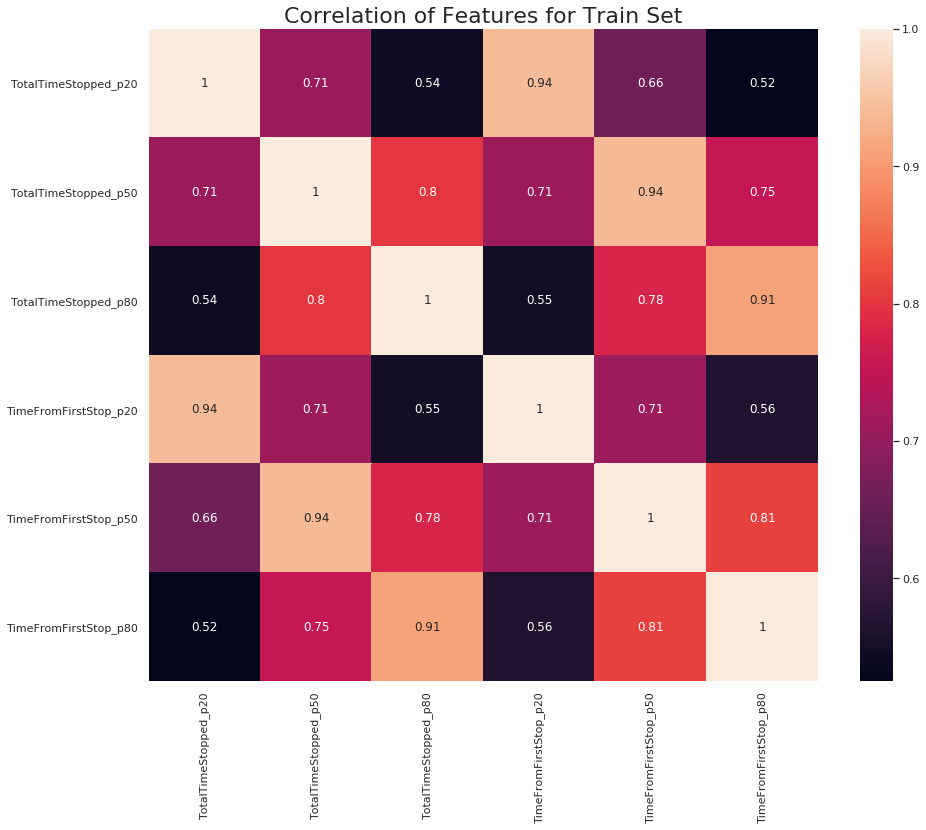

In [47]:
# Heatmap Target Features
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set', fontsize=22)
sns.heatmap(df_train[t_stopped
                     + t_first_stopped
                    # + d_first_stopped
                     ].astype(float).corr(),
            vmax=1.0, annot=True)
plt.show()

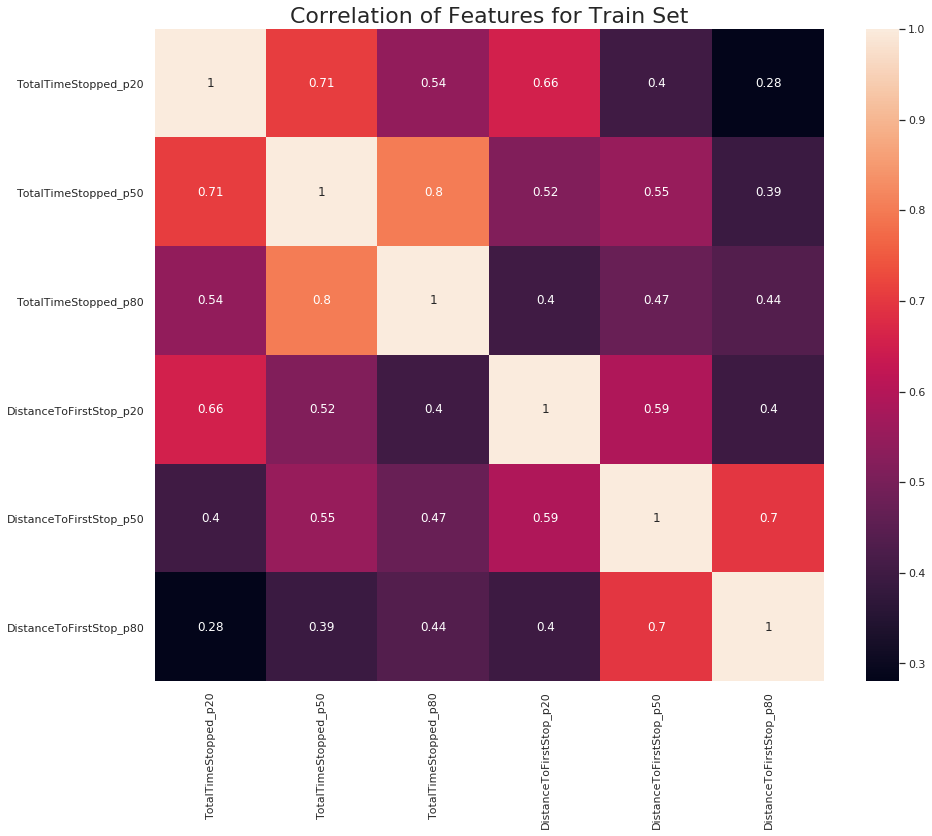

In [48]:
# Heatmap Target Features
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set', fontsize=22)
sns.heatmap(df_train[t_stopped + 
                    #  t_first_stopped +
                     d_first_stopped].astype(float).corr(),
            vmax=1.0, annot=True)
plt.show()

In [0]:
# Scaling the target
from sklearn.preprocessing import minmax_scale

target_cols = t_stopped + d_first_stopped

In [0]:
for col in target_cols:
    df_train[col+str("_minmax")] = (minmax_scale(df_train[col], feature_range=(0, 1)))

min_max_cols = ['TotalTimeStopped_p20_minmax',
                'TotalTimeStopped_p50_minmax',
                'TotalTimeStopped_p80_minmax',
                'DistanceToFirstStop_p20_minmax',
                'DistanceToFirstStop_p50_minmax',
                'DistanceToFirstStop_p80_minmax']



In [53]:
df_train[min_max_cols].sample(10)

,TotalTimeStopped_p20_minmax,TotalTimeStopped_p50_minmax,TotalTimeStopped_p80_minmax,DistanceToFirstStop_p20_minmax,DistanceToFirstStop_p50_minmax,DistanceToFirstStop_p80_minmax
854314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
114479,0.026846,0.029333,0.041940,0.029497,0.021711,0.019293
203549,0.000000,0.029333,0.056356,0.000000,0.018414,0.019832
760604,0.000000,0.000000,0.039318,0.000000,0.000000,0.015934
565146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
401118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
469523,0.000000,0.029333,0.022280,0.000000,0.022202,0.018680
463221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
189548,0.000000,0.000000,0.055046,0.000000,0.000000,0.013973
23934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [54]:
# PCA
# 측정항목의 분포를 확인하기 위해 PCA를 적용하여 데이터 차원을 축소해보자.
pca = PCA(n_components=3, random_state=5)

principalComponents = pca.fit_transform(df_train[min_max_cols])

principalDf = pd.DataFrame(principalComponents)

principalDf.head()

,0,1,2
0,-0.041899,-0.001683,0.011591
1,-0.041899,-0.001683,0.011591
2,-0.041899,-0.001683,0.011591
3,-0.041899,-0.001683,0.011591
4,-0.041899,-0.001683,0.011591


In [55]:
prefix = 'Target_PCA'
principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

df_train = pd.concat([df_train, principalDf], axis=1)

df_train.sample(10)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,TotalTimeStopped_p20_minmax,TotalTimeStopped_p50_minmax,TotalTimeStopped_p80_minmax,DistanceToFirstStop_p20_minmax,DistanceToFirstStop_p50_minmax,DistanceToFirstStop_p80_minmax,Target_PCA0,Target_PCA1,Target_PCA2
7043,1928400,8,33.810408,-84.438777,Chattahoochee Avenue Northwest,Marietta Boulevard Northwest,NW,S,22,0,12,Chattahoochee Avenue Northwest_NW_Marietta Boulevard Northwest_S,0.0,11.0,16.0,19.0,50.0,0.0,22.0,31.0,35.0,117.0,0.0,51.9,53.8,57.9,406.1,Atlanta,0.000000,0.042667,0.065531,0.000000,0.018870,0.099554,0.066112,0.047828,-0.031894
291968,2213325,916,42.335083,-71.055268,Old Colony Avenue,Old Colony Avenue,SE,SE,14,0,10,Old Colony Avenue_SE_Old Colony Avenue_SE,0.0,0.0,0.0,10.0,25.0,0.0,0.0,0.0,24.0,37.0,0.0,0.0,0.0,70.0,92.7,Boston,0.000000,0.000000,0.032765,0.000000,0.000000,0.022725,-0.015355,0.007485,-0.013211
774493,2695850,1552,39.961570,-75.224540,Arch Street,North 52nd Street,E,S,21,1,9,Arch Street_E_North 52nd Street_S,12.0,24.0,24.0,35.0,66.0,18.0,38.0,38.0,41.0,88.0,41.7,44.5,44.5,50.0,55.4,Philadelphia,0.040268,0.064000,0.086501,0.021925,0.015608,0.013581,0.065550,-0.043591,-0.002700
818614,2739971,1799,39.956484,-75.221558,South 50th Street,South 50th Street,N,N,15,0,11,South 50th Street_N_South 50th Street_N,7.0,29.0,37.0,40.0,52.0,15.0,40.0,60.0,63.0,109.0,57.5,64.9,87.6,127.6,328.3,Philadelphia,0.023490,0.098667,0.068152,0.030233,0.030725,0.080481,0.107441,0.008413,0.005571
636006,2557363,843,39.964629,-75.177984,Spring Garden Street,Eakins Oval,W,W,7,0,7,Spring Garden Street_W_Eakins Oval_W,13.0,32.0,35.0,42.0,49.0,16.0,49.0,57.0,65.0,68.0,21.7,86.2,91.4,95.8,105.2,Philadelphia,0.043624,0.093333,0.064220,0.011410,0.032058,0.025789,0.081524,-0.035787,0.018686
425855,2347212,1957,41.837422,-87.695018,West 31st Street,West 31st Street,W,W,8,0,12,West 31st Street_W_West 31st Street_W,0.0,0.0,0.0,16.0,35.0,0.0,0.0,0.0,24.0,43.0,0.0,0.0,0.0,62.9,67.9,Chicago,0.000000,0.000000,0.045872,0.000000,0.000000,0.016645,-0.011287,-0.000885,-0.021113
400777,2322134,1399,41.864982,-87.618995,South Lake Shore Drive,South Lake Shore Drive,N,N,15,1,12,South Lake Shore Drive_N_South Lake Shore Drive_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chicago,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.041899,-0.001683,0.011591
851147,2772504,1968,39.913549,-75.221635,Essington Avenue,South 67th Street,S,E,13,0,6,Essington Avenue_S_South 67th Street_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.041899,-0.001683,0.011591
415540,2336897,1754,41.793660,-87.664581,South Ashland Avenue,South Ashland Avenue,S,S,14,0,11,South Ashland Avenue_S_South Ashland Avenue_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chicago,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.041899,-0.001683,0.011591
851248,2772605,1968,39.913549,-75.221635,Essington Avenue,Essington Avenue,N,N,23,1,9,Essington Avenue_N_Essington Avenue_N,0.0,0.0,0.0,11.0,23.0,0.0,0.0,0.0,18.0,27.0,0.0,0.0,0.0,45.1,54.0,Philadelphia,0.000000,0.000000,0.030144,0.000000,0.000000,0.013238,-0.020790,0.000666,-0.010206


In [56]:
pca

PCA(copy=True, iterated_power='auto', n_components=3, random_state=5,
    svd_solver='auto', tol=0.0, whiten=False)

In [57]:
pca.explained_variance_ratio_

array([0.64295211, 0.19587815, 0.0731484 ])

In [58]:
pca.explained_variance_ratio_[:2].sum()

0.8388302642985763

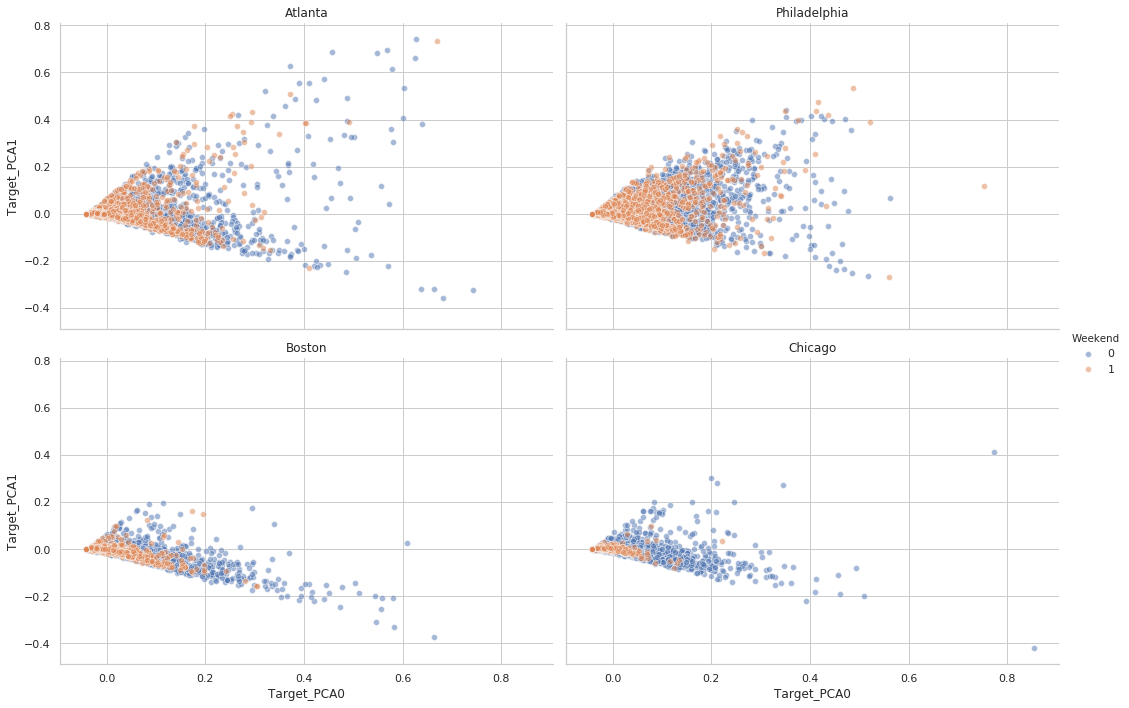

In [59]:
# Scatter plot of cities by the PCA
g = sns.FacetGrid(df_train.sample(50000), col="City",
                  col_wrap=2, height=5, aspect=1.5, hue="Weekend")
g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", alpha=.5).add_legend()
g.set_titles('{col_name}', fontsize=17)
plt.show()

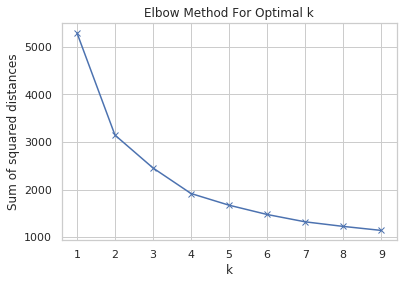

In [60]:
# KMeans Clusterization
# 데이터에 있는 정확한 수의 군집을 찾아보고 best quantity로 kmeans를 구현해보자
ssd = []

K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=4)
    km = km.fit(df_train[min_max_cols])
    ssd.append(km.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.show()

4 부터 조금씩 작아지므로 클러스터를 4로 정하자

In [0]:
km = KMeans(n_clusters=4, random_state=4)
km = km.fit(df_train[min_max_cols])
df_train['clusters_T'] = km.predict(df_train[min_max_cols])

In [63]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,TotalTimeStopped_p20_minmax,TotalTimeStopped_p50_minmax,TotalTimeStopped_p80_minmax,DistanceToFirstStop_p20_minmax,DistanceToFirstStop_p50_minmax,DistanceToFirstStop_p80_minmax,Target_PCA0,Target_PCA1,Target_PCA2,clusters_T
814904,2736261,1778,39.948883,-75.160568,South 12th Street,Walnut Street,S,W,6,0,7,South 12th Street_S_Walnut Street_W,0.0,0.0,6.0,9.0,17.0,0.0,0.0,16.0,18.0,28.0,0.0,0.0,34.1,50.8,53.6,Philadelphia,0.0,0.016,0.022280,0.0,0.01196,0.013140,-0.011495,-0.000236,0.001600,0
633392,2554749,831,40.008645,-75.068888,Tacony Street,Tacony Street,E,E,11,1,8,Tacony Street_E_Tacony Street_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,0.0,0.000,0.000000,0.0,0.00000,0.000000,-0.041899,-0.001683,0.011591,0
101508,2022865,324,33.773195,-84.408891,Donald Lee Hollowell Parkway Northwest,Northside Drive Northwest,E,N,10,1,10,Donald Lee Hollowell Parkway Northwest_E_Northside Drive Northwest_N,0.0,0.0,0.0,22.0,68.0,0.0,0.0,0.0,28.0,87.0,0.0,0.0,0.0,59.8,73.8,Atlanta,0.0,0.000,0.089122,0.0,0.00000,0.018092,0.011422,-0.011438,-0.050052,3
467656,2389013,7,39.970466,-75.148970,West Girard Avenue,West Girard Avenue,E,E,17,0,9,West Girard Avenue_E_West Girard Avenue_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,0.0,0.000,0.000000,0.0,0.00000,0.000000,-0.041899,-0.001683,0.011591,0
824408,2745765,1836,39.956175,-75.194155,Market Street,North 36th Street,W,W,19,0,7,Market Street_W_North 36th Street_W,0.0,0.0,0.0,7.0,15.0,0.0,0.0,0.0,19.0,26.0,0.0,0.0,0.0,67.2,72.1,Philadelphia,0.0,0.000,0.019659,0.0,0.00000,0.017675,-0.024228,0.007024,-0.003828,0


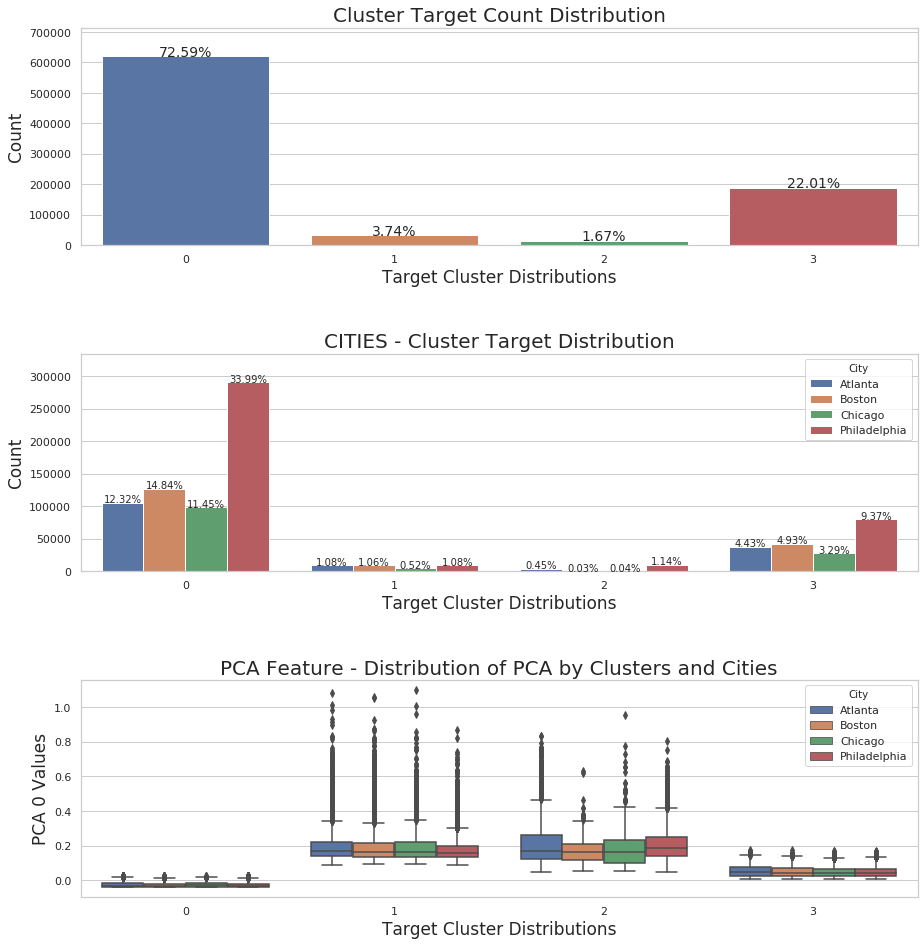

In [64]:
# Ploting Clusters
tmp = pd.crosstab(df_train['City'], df_train['clusters_T'], normalize='columns').unstack('City').reset_index().rename(columns={0:"perc"})

total = len(df_train)
plt.figure(figsize=(15, 16))

plt.subplot(311)
g = sns.countplot(x="clusters_T", data=df_train)
g.set_title("Cluster Target Count Distribution", fontsize=20)
g.set_ylabel("Count", fontsize=17)
g.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes = []

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width() / 2.,
           height + 3,
           '{:1.2f}%'.format(height/total*100),
           ha="center", fontsize=14)
g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(312)
g1 = sns.countplot(x="clusters_T", data=df_train, hue='City')
g1.set_title("CITIES - Cluster Target Distribution", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]

for p in g1.patches:
    height = p.get_height()
    sizes.append(height)
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10)
g1.set_ylim(0, max(sizes) * 1.15)

plt.subplot(313)
g1 = sns.boxplot(x="clusters_T", y='Target_PCA0', 
                 data=df_train, hue='City')
g1.set_title("PCA Feature - Distribution of PCA by Clusters and Cities", 
             fontsize=20)
g1.set_ylabel("PCA 0 Values",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)

plt.subplots_adjust(hspace = 0.5)

plt.show()

In [66]:
tmp

,clusters_T,City,perc
0,0,Atlanta,0.169679
1,0,Boston,0.204389
2,0,Chicago,0.157696
3,0,Philadelphia,0.468236
4,1,Atlanta,0.289160
5,1,Boston,0.282974
6,1,Chicago,0.140206
7,1,Philadelphia,0.287660
8,2,Atlanta,0.269422
9,2,Boston,0.020245


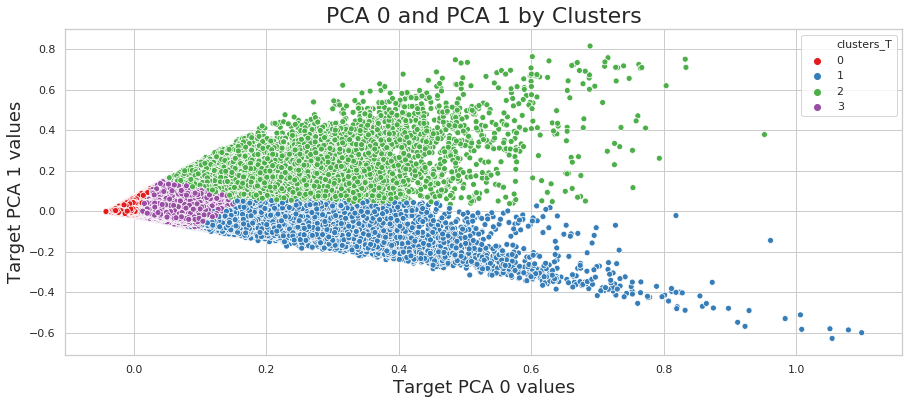

In [65]:
# PCA values by CLUSTERS
plt.figure(figsize=(15,6))

sns.scatterplot(x="Target_PCA0", y="Target_PCA1",
                hue='clusters_T', data=df_train,
                palette='Set1')
plt.title("PCA 0 and PCA 1 by Clusters", fontsize=22)
plt.ylabel("Target PCA 1 values", fontsize=18)
plt.xlabel("Target PCA 0 values", fontsize=18)

plt.show()

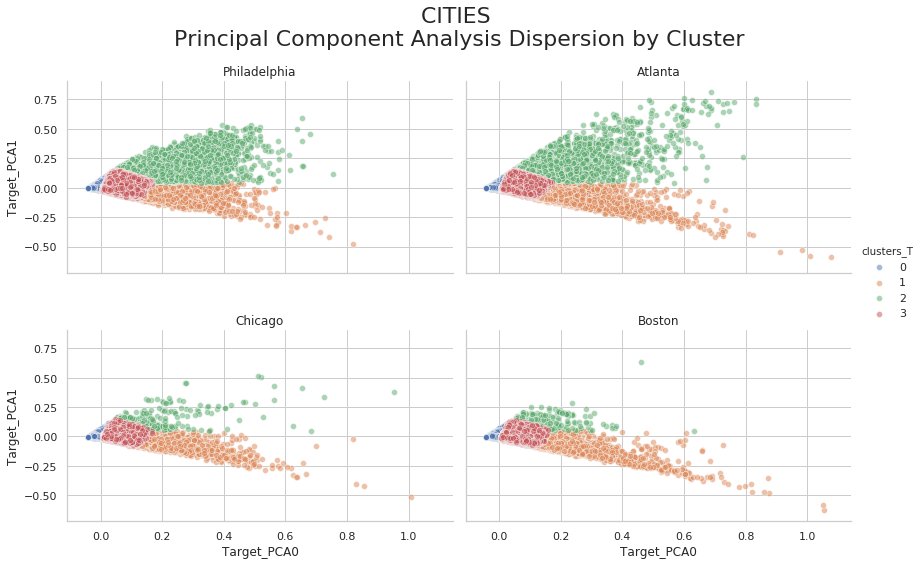

In [67]:
# PCA Dispersion by clusters and by Each City
g = sns.FacetGrid(df_train.sample(500000), col="City",
                  col_wrap=2, height=4, aspect=1.5,
                  hue="clusters_T")

g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", alpha=.5).add_legend()
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by Cluster", fontsize=22)

plt.subplots_adjust(hspace=0.3, top=.85)
plt.show()

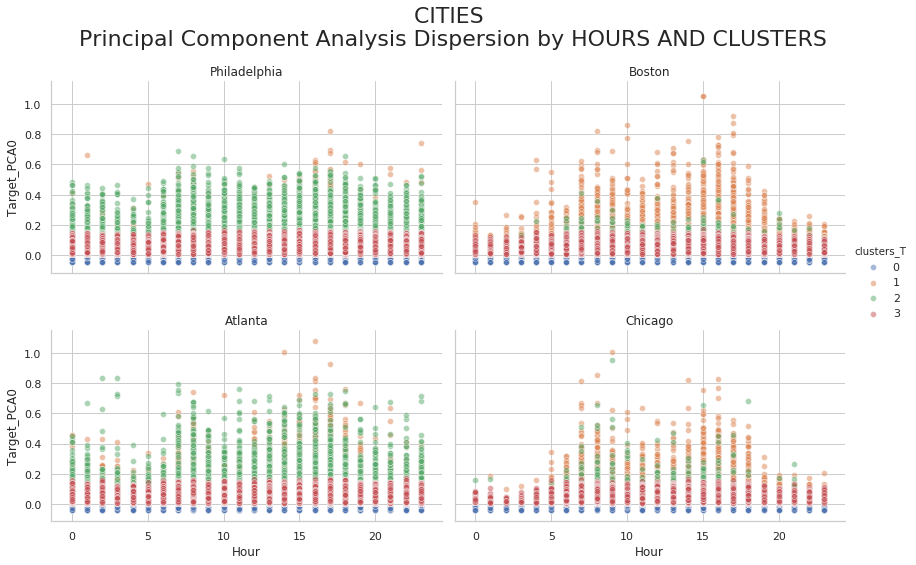

In [68]:
# Clusters by the Hours
g = sns.FacetGrid(df_train.sample(500000), col="City", col_wrap=2, height=4, aspect=1.5, hue='clusters_T')

g.map(sns.scatterplot, "Hour", "Target_PCA0", alpha=.5).add_legend()
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by HOURS AND CLUSTERS", fontsize=22)

plt.subplots_adjust(hspace=0.3, top=.85)
plt.show()

In [69]:
round(pd.crosstab([df_train['clusters_T'], df_train['Weekend']], df_train['City'], normalize='index') * 100, 0)

City                Atlanta  Boston  Chicago  Philadelphia
clusters_T Weekend                                        
0          0        15.0     22.0    21.0     42.0        
           1        22.0     16.0    3.0      59.0        
1          0        27.0     31.0    16.0     26.0        
           1        41.0     15.0    2.0      42.0        
2          0        26.0     3.0     4.0      68.0        
           1        30.0     1.0     0.0      69.0        
3          0        18.0     25.0    19.0     39.0        
           1        29.0     14.0    2.0      56.0

# Modeling

In [0]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [0]:
# Hour Feature
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

df_train = date_cyc_enc(df_train, 'Hour', 24)
df_test = date_cyc_enc(df_test, 'Hour', 24) 

In [72]:
df_train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Hour_sin,Hour_cos
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,6,Marietta Boulevard Northwest_NW_Marietta Boulevard Northwest_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,0.000000,1.000000
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,6,Marietta Boulevard Northwest_SE_Marietta Boulevard Northwest_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,0.000000,1.000000
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,6,Marietta Boulevard Northwest_NW_Marietta Boulevard Northwest_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,0.258819,0.965926
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,6,Marietta Boulevard Northwest_SE_Marietta Boulevard Northwest_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,0.258819,0.965926
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,6,Marietta Boulevard Northwest_NW_Marietta Boulevard Northwest_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,0.500000,0.866025


In [0]:
# Flag - is day?
df_train['is_day'] = df_train['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)
df_test['is_day'] = df_test['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)

df_train['is_morning'] = df_train['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)
df_test['is_morning'] = df_test['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)

df_train['is_night'] = df_train['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)
df_test['is_night'] = df_test['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)

df_train['is_day_weekend'] = np.where((df_train['is_day'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_day_weekend'] = np.where((df_test['is_day'] == 1) & (df_train['Weekend'] == 1), 1,0)

df_train['is_mor_weekend'] = np.where((df_train['is_morning'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_mor_weekend'] = np.where((df_test['is_morning'] == 1) & (df_train['Weekend'] == 1), 1,0)

df_train['is_nig_weekend'] = np.where((df_train['is_night'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_nig_weekend'] = np.where((df_test['is_night'] == 1) & (df_train['Weekend'] == 1), 1,0)

In [74]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend
391299,2312656,1188,41.721159,-87.666555,West 95th Street,West 95th Street,W,W,18,0,11,West 95th Street_W_West 95th Street_W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chicago,-1.000000,-1.836970e-16,0,0,1,0,0,0
630360,2551717,826,40.033685,-75.046790,Frankford Avenue,Frankford Avenue,SW,W,18,0,6,Frankford Avenue_SW_Frankford Avenue_W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,-1.000000,-1.836970e-16,0,0,1,0,0,0
630475,2551832,826,40.033685,-75.046790,Tyson Avenue,Tyson Avenue,SE,SE,13,0,7,Tyson Avenue_SE_Tyson Avenue_SE,0.0,0.0,0.0,10.0,31.0,0.0,0.0,0.0,42.0,79.0,0.0,0.0,0.0,104.8,542.8,Philadelphia,-0.258819,-9.659258e-01,1,0,0,0,0,0
854454,2775811,1977,39.965002,-75.159516,Wallace Street,Wallace Street,E,E,23,1,11,Wallace Street_E_Wallace Street_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,-0.258819,9.659258e-01,0,0,0,0,0,0
502076,2423433,152,39.949435,-75.158809,South 11th Street,South 11th Street,N,N,18,1,12,South 11th Street_N_South 11th Street_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,-1.000000,-1.836970e-16,0,0,1,0,0,1


In [75]:
# Intersec - Concatenating IntersectionId and City
df_train["Intersec"] = df_train["IntersectionId"].astype(str) + df_train["City"]
df_test["Intersec"] = df_test["IntersectionId"].astype(str) + df_test["City"]

print(df_train["Intersec"].sample(6).values)

['701Philadelphia' '1069Philadelphia' '147Chicago' '494Atlanta'
 '1304Philadelphia' '534Boston']


In [0]:
# Label Encoder of Intersection + City
le = LabelEncoder()

le.fit(pd.concat([df_train["Intersec"],df_test["Intersec"]]).drop_duplicates().values)
df_train["Intersec"] = le.transform(df_train["Intersec"])
df_test["Intersec"] = le.transform(df_test["Intersec"])

In [77]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend,Intersec
401346,2322703,1414,41.786898,-87.654689,West 59th Street,West 59th Street,E,E,5,0,11,West 59th Street_E_West 59th Street_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chicago,0.965926,2.588190e-01,0,0,0,0,0,0,1252
323112,2244469,1189,42.335970,-71.120520,School Street,Harvard Street,NE,NW,10,0,7,School Street_NE_Harvard Street_NW,0.0,10.0,24.0,36.0,43.0,0.0,24.0,35.0,43.0,52.0,0.0,44.5,55.5,55.8,62.8,Boston,0.500000,-8.660254e-01,1,0,0,0,0,0,622
834151,2755508,1882,39.981548,-75.224043,Parkside Avenue,North 52nd Street,W,SW,10,0,10,Parkside Avenue_W_North 52nd Street_SW,25.0,44.0,50.0,55.0,61.0,46.0,66.0,103.0,130.0,153.0,63.9,80.5,289.9,507.8,1062.7,Philadelphia,0.500000,-8.660254e-01,1,0,0,0,0,0,2329
154673,2076030,511,33.750549,-84.395169,Trinity Avenue Southwest,Trinity Avenue Southwest,E,SE,18,0,9,Trinity Avenue Southwest_E_Trinity Avenue Southwest_SE,0.0,16.0,16.0,19.0,26.0,0.0,24.0,25.0,29.0,35.0,0.0,58.4,59.6,63.2,70.8,Atlanta,-1.000000,-1.836970e-16,0,0,1,0,0,0,4765
536920,2458277,342,39.931715,-75.168082,South Broad Street,Dickinson Street,S,E,17,0,10,South Broad Street_S_Dickinson Street_E,0.0,10.0,21.0,25.0,37.0,0.0,25.0,32.0,34.0,44.0,0.0,52.6,54.0,55.7,60.0,Philadelphia,-0.965926,-2.588190e-01,1,0,0,0,0,0,4054


In [0]:
# Street Feature
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

In [0]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
    return 0

In [80]:
df_train.columns

Index(['RowId', 'IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Path', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'City',
       'Hour_sin', 'Hour_cos', 'is_day', 'is_morning', 'is_night',
       'is_day_weekend', 'is_mor_weekend', 'is_nig_weekend', 'Intersec'],
      dtype='object')

In [0]:
df_train['EntryType'] = df_train['EntryStreetName'].apply(encode)
df_train['ExitType'] = df_train['ExitStreetName'].apply(encode)
df_test['EntryType'] = df_test['EntryStreetName'].apply(encode)
df_test['ExitType'] = df_test['ExitStreetName'].apply(encode)

In [82]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend,Intersec,EntryType,ExitType
511636,2432993,190,40.038997,-75.059760,Roosevelt Boulevard,Roosevelt Boulevard,NE,NE,13,1,7,Roosevelt Boulevard_NE_Roosevelt Boulevard_NE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,-0.258819,-0.965926,1,0,0,1,0,0,2396,4,4
840539,2761896,1911,39.930285,-75.176606,South 19th Street,Morris Street,S,E,10,0,10,South 19th Street_S_Morris Street_E,0.0,0.0,0.0,8.0,27.0,0.0,0.0,0.0,52.0,62.0,0.0,0.0,0.0,188.0,245.9,Philadelphia,0.500000,-0.866025,1,0,0,0,0,0,2400,2,2
564314,2485671,454,39.959892,-75.193795,Powelton Avenue,Powelton Avenue,W,W,7,0,10,Powelton Avenue_W_Powelton Avenue_W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,0.965926,-0.258819,0,1,0,0,0,0,4522,2,2
838796,2760153,1898,40.037123,-75.062837,Roosevelt Boulevard,Roosevelt Boulevard,SW,W,15,1,7,Roosevelt Boulevard_SW_Roosevelt Boulevard_W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,-0.707107,-0.707107,1,0,0,1,0,0,2364,4,4
302815,2224172,1015,42.282012,-71.058922,Gallivan Boulevard,Gallivan Boulevard,E,E,11,1,9,Gallivan Boulevard_E_Gallivan Boulevard_E,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,69.8,Boston,0.258819,-0.965926,1,0,0,1,0,0,49,4,4


In [0]:
# Encoding the Regions
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

In [0]:
# Applying the transformation in Entry and Exit Heading Columns
df_train['EntryHeading'] = df_train['EntryHeading'].map(directions)
df_train['ExitHeading'] = df_train['ExitHeading'].map(directions)

df_test['EntryHeading'] = df_test['EntryHeading'].map(directions)
df_test['ExitHeading'] = df_test['ExitHeading'].map(directions)

In [85]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend,Intersec,EntryType,ExitType
156378,2077735,520,33.757096,-84.382228,Piedmont Avenue Northeast,Piedmont Avenue Northeast,0.00,0.00,23,1,7,Piedmont Avenue Northeast_N_Piedmont Avenue Northeast_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,-2.588190e-01,0.965926,0,0,0,0,0,0,4804,2,2
596305,2517662,621,39.938853,-75.174749,South 19th Street,South 19th Street,1.00,1.00,7,0,12,South 19th Street_S_South 19th Street_S,0.0,0.0,0.0,16.0,39.0,0.0,0.0,0.0,27.0,48.0,0.0,0.0,0.0,65.4,103.6,Philadelphia,9.659258e-01,-0.258819,0,1,0,0,0,0,5145,2,2
183452,2104809,177,42.328172,-71.097059,Columbus Avenue,Columbus Avenue,0.25,0.25,9,1,9,Columbus Avenue_NE_Columbus Avenue_NE,0.0,0.0,0.0,13.0,45.0,0.0,0.0,0.0,21.0,51.0,0.0,0.0,0.0,51.7,64.7,Boston,7.071068e-01,-0.707107,1,1,0,1,1,0,2090,2,2
339610,2260967,110,41.960665,-87.752402,West Montrose Avenue,West Montrose Avenue,1.50,1.50,22,0,10,West Montrose Avenue_W_West Montrose Avenue_W,0.0,0.0,0.0,14.0,15.0,0.0,0.0,0.0,22.0,31.0,0.0,0.0,0.0,59.6,79.2,Chicago,-5.000000e-01,0.866025,0,0,0,0,0,0,361,2,2
61098,1982455,176,33.825781,-84.362612,Sidney Marcus Boulevard Northeast,Sidney Marcus Boulevard Northeast,1.50,1.50,12,1,11,Sidney Marcus Boulevard Northeast_W_Sidney Marcus Boulevard Northeast_W,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,67.4,Atlanta,1.224647e-16,-1.000000,1,0,0,1,0,0,2065,4,4


In [0]:
# Difference between the regions
df_train['diffHeading'] = df_train['EntryHeading']-df_train['ExitHeading']  
df_test['diffHeading'] = df_test['EntryHeading']-df_test['ExitHeading'] 

In [87]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend,Intersec,EntryType,ExitType,diffHeading
104009,2025366,331,33.800471,-84.415963,Bellemeade Avenue Northwest,Howell Mill Road Northwest,1.50,1.00,17,0,11,Bellemeade Avenue Northwest_W_Howell Mill Road Northwest_S,39.0,97.0,105.0,119.0,196.0,64.0,131.0,135.0,173.0,260.0,83.1,110.3,113.9,119.0,226.8,Atlanta,-0.965926,-0.258819,1,0,0,0,0,0,4005,2,1,0.5
648611,2569968,911,40.007212,-75.123425,Erie Avenue,Erie Avenue,0.50,0.50,13,1,8,Erie Avenue_E_Erie Avenue_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,-0.258819,-0.965926,1,0,0,1,0,0,6100,2,2,0.0
453675,2375032,2593,41.972764,-87.713495,North Kimball Avenue,North Kimball Avenue,1.00,1.00,11,0,11,North Kimball Avenue_S_North Kimball Avenue_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chicago,0.258819,-0.965926,1,0,0,0,0,0,3419,2,2,0.0
771135,2692492,1541,40.002274,-75.220191,Belmont Avenue,Belmont Avenue,1.00,1.00,9,0,12,Belmont Avenue_S_Belmont Avenue_S,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,54.8,Philadelphia,0.707107,-0.707107,1,1,0,0,0,0,1546,2,2,0.0
640727,2562084,868,40.039583,-75.045817,Cottman Avenue,Cottman Avenue,1.75,1.75,10,1,11,Cottman Avenue_NW_Cottman Avenue_NW,0.0,0.0,0.0,8.0,19.0,0.0,0.0,0.0,15.0,33.0,0.0,0.0,0.0,69.6,75.9,Philadelphia,0.500000,-0.866025,1,0,0,1,0,0,5954,2,2,0.0


In [0]:
# Getting the binary if the entry and exit was in the same street
df_train["same_str"] = (df_train["EntryStreetName"] == df_train["ExitStreetName"]).astype(int)
df_test["same_str"] = (df_test["EntryStreetName"] == df_test["ExitStreetName"]).astype(int)

In [89]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend,Intersec,EntryType,ExitType,diffHeading,same_str
507479,2428836,176,39.974772,-75.198334,NaN,West Girard Avenue,1.00,0.50,1,0,9,Unknown_S_West Girard Avenue_E,43.0,44.0,44.0,48.0,67.0,52.0,52.0,52.0,56.0,75.0,58.5,58.6,58.6,62.8,66.4,Philadelphia,0.258819,0.965926,0,0,0,0,0,0,2068,0,2,0.50,0
735393,2656750,1371,40.024563,-75.123220,Rising Sun Avenue,Rising Sun Avenue,0.25,0.25,3,0,7,Rising Sun Avenue_NE_Rising Sun Avenue_NE,0.0,0.0,0.0,8.0,19.0,0.0,0.0,0.0,37.0,44.0,0.0,0.0,0.0,101.2,181.6,Philadelphia,0.707107,0.707107,0,0,0,0,0,0,1156,2,2,0.00,1
125081,2046438,399,33.744778,-84.291001,Candler Road Southeast,Candler Road Southeast,0.75,0.75,1,1,11,Candler Road Southeast_SE_Candler Road Southeast_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,0.258819,0.965926,0,0,0,0,0,0,4282,1,1,0.00,1
765627,2686984,1511,39.945872,-75.240313,South Cobbs Creek Parkway,South Cobbs Creek Parkway,1.75,1.50,9,1,11,South Cobbs Creek Parkway_NW_South Cobbs Creek Parkway_W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,0.707107,-0.707107,1,1,0,1,1,0,1474,0,0,0.25,1
360122,2281479,559,41.892386,-87.635594,West Ohio Street,West Ohio Street,0.50,0.50,9,0,10,West Ohio Street_E_West Ohio Street_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chicago,0.707107,-0.707107,1,1,0,0,0,0,4933,2,2,0.00,1


In [0]:
# Concatenating City and Month
df_train['city_month'] = df_train["City"] + df_train["Month"].astype(str)
df_test['city_month'] = df_test["City"] + df_test["Month"].astype(str)

In [91]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend,Intersec,EntryType,ExitType,diffHeading,same_str,city_month
530357,2451714,291,39.922593,-75.185212,Passyunk Avenue,Passyunk Avenue,0.50,0.50,8,0,8,Passyunk Avenue_E_Passyunk Avenue_E,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,75.6,Philadelphia,0.866025,-0.500000,1,1,0,0,0,0,3832,2,2,0.00,1,Philadelphia8
398276,2319633,1322,41.893379,-87.647687,North Halsted Street,North Halsted Street,0.00,0.00,3,0,10,North Halsted Street_N_North Halsted Street_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chicago,0.707107,0.707107,0,0,0,0,0,0,1043,2,2,0.00,1,Chicago10
27639,1948996,81,33.788519,-84.428267,Marietta Boulevard Northwest,Marietta Boulevard Northwest,0.75,1.00,11,1,10,Marietta Boulevard Northwest_SE_Marietta Boulevard Northwest_S,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,78.8,Atlanta,0.258819,-0.965926,1,0,0,1,0,0,5793,4,4,-0.25,1,Atlanta10
236731,2158088,522,42.312960,-71.057207,Savin Hill Avenue,Dorchester Avenue,1.50,1.00,8,0,11,Savin Hill Avenue_W_Dorchester Avenue_S,0.0,7.0,7.0,52.0,54.0,0.0,24.0,24.0,61.0,65.0,0.0,61.1,61.1,66.0,105.0,Boston,0.866025,-0.500000,1,1,0,0,0,0,4811,2,2,0.50,0,Boston11
817112,2738469,1796,39.980196,-75.269258,City Avenue,Haverford Avenue,0.25,0.75,13,0,9,City Avenue_NE_Haverford Avenue_SE,0.0,25.0,25.0,30.0,48.0,0.0,38.0,38.0,43.0,58.0,0.0,42.1,42.1,47.5,74.4,Philadelphia,-0.258819,-0.965926,1,0,0,0,0,0,2127,2,2,-0.50,0,Philadelphia9


In [0]:
# Month rainfall ratio by city and seasons
monthly_rainfall = {'Atlanta1': 5.02, 'Atlanta5': 3.95, 'Atlanta6': 3.63, 'Atlanta7': 5.12, 
                    'Atlanta8': 3.67, 'Atlanta9': 4.09,'Atlanta10': 3.11, 'Atlanta11': 4.10, 
                    'Atlanta12': 3.82, 'Boston1': 3.92, 'Boston5': 3.24, 'Boston6': 3.22,
                    'Boston7': 3.06, 'Boston8': 3.37, 'Boston9': 3.47, 'Boston10': 3.79,
                    'Boston11': 3.98, 'Boston12': 3.73, 'Chicago1': 1.75, 'Chicago5': 3.38,
                    'Chicago6': 3.63, 'Chicago7': 3.51, 'Chicago8': 4.62, 'Chicago9': 3.27,
                    'Chicago10': 2.71,  'Chicago11': 3.01, 'Chicago12': 2.43, 
                    'Philadelphia1': 3.52, 'Philadelphia5': 3.88, 'Philadelphia6': 3.29,
                    'Philadelphia7': 4.39, 'Philadelphia8': 3.82, 'Philadelphia9':3.88 ,
                    'Philadelphia10': 2.75, 'Philadelphia11': 3.16, 'Philadelphia12': 3.31}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
df_train["average_rainfall"] = df_train['city_month'].map(monthly_rainfall)
df_test["average_rainfall"] = df_test['city_month'].map(monthly_rainfall)

In [93]:
# Getting Dummies
print(f'Shape before dummy transformation: {df_train.shape}')
df_train = pd.get_dummies(df_train, columns=['City'],\
                          prefix=['City'], drop_first=False)

print(f'Shape after dummy transformation: {df_train.shape}')

df_test = pd.get_dummies(df_test, columns=['City'],\
                          prefix=['City'], drop_first=False)

Shape before dummy transformation: (856387, 43)
Shape after dummy transformation: (856387, 46)


In [94]:
df_train.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend,Intersec,EntryType,ExitType,diffHeading,same_str,city_month,average_rainfall,City_Atlanta,City_Boston,City_Chicago,City_Philadelphia
61938,1983295,181,33.732109,-84.413735,Lee St Conn Southwest,West Whitehall Street Southwest,1.75,1.25,10,0,6,Lee St Conn Southwest_NW_West Whitehall Street Southwest_SW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,-0.866025,1,0,0,0,0,0,2183,0,2,0.5,0,Atlanta6,3.63,1,0,0,0
791784,2713141,1648,39.958689,-75.167172,Franklin Town Boulevard,North 17th Street,1.00,1.00,10,0,8,Franklin Town Boulevard_S_North 17th Street_S,0.0,9.0,13.0,20.0,30.0,0.0,18.0,24.0,29.0,39.0,0.0,37.3,38.2,50.8,62.3,0.500000,-0.866025,1,0,0,0,0,0,1785,4,2,0.0,0,Philadelphia8,3.82,0,0,0,1
170527,2091884,90,42.346337,-71.063193,Herald Street,Herald Street,0.50,0.50,2,1,11,Herald Street_E_Herald Street_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.866025,0,0,0,0,0,0,6093,2,2,0.0,1,Boston11,3.98,0,1,0,0
88895,2010252,283,33.781782,-84.380467,Piedmont Avenue Northeast,10th Street Northeast,0.00,1.50,3,0,11,Piedmont Avenue Northeast_N_10th Street Northeast_W,0.0,12.0,12.0,22.0,29.0,0.0,22.0,22.0,51.0,83.0,0.0,51.9,51.9,233.6,703.6,0.707107,0.707107,0,0,0,0,0,0,3762,2,2,-1.5,0,Atlanta11,4.10,1,0,0,0
780072,2701429,1585,39.949553,-75.165948,Walnut Street,Walnut Street,1.50,1.50,21,1,9,Walnut Street_W_Walnut Street_W,0.0,6.0,6.0,13.0,27.0,0.0,19.0,19.0,20.0,34.0,0.0,28.5,63.9,78.1,78.4,-0.707107,0.707107,0,0,0,0,0,0,1644,2,2,0.0,1,Philadelphia9,3.88,0,0,0,1


In [0]:
# MinMax Scaling the lat and long
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in ['Latitude','Longitude']:
    scaler.fit(df_train[col].values.reshape(-1, 1))
    df_train[col] = scaler.transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = scaler.transform(df_test[col].values.reshape(-1, 1))

In [0]:
# Droppping not used features
df_train.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'
              ],axis=1, inplace=True)
df_test.drop(['RowId', 'Path',
              'EntryStreetName','ExitStreetName'],axis=1, inplace=True)

In [0]:
interesting_feat = ['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
                    'ExitHeading', 'Hour', 'Weekend', 'Month',
                    'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
                    'is_nig_weekend', #  'Hour_sin',
                    'Hour', 'same_str', 'Intersec', 'EntryType',
                    'ExitType', 'diffHeading', 'average_rainfall', 'is_day',
                    'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                    'City_Atlanta']

total_time = ['TotalTimeStopped_p20',
              'TotalTimeStopped_p50', 
              'TotalTimeStopped_p80']

target_stopped = ['DistanceToFirstStop_p20',
                  'DistanceToFirstStop_p50',
                  'DistanceToFirstStop_p80']

In [0]:
# Setting X and y
X = df_train[interesting_feat]
y = df_train[total_time + target_stopped]

X_test = df_test[interesting_feat]

In [99]:
print(f'Shape of X: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X: (856387, 25)
Shape of X_test: (1921357, 25)


In [0]:
# Reduce memory usage
# X = reduce_mem_usage(X) 
# X_test = reduce_mem_usage(X_test)

In [0]:
# Spliting data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

In [0]:
# Hyperopt Space
hyper_space = {'objective': 'regression',
               'metric':'rmse',
               'boosting':'gbdt', 
               'gpu_device_id': 0,
               #'n_estimators': hp.choice('n_estimators', [25, 40, 50, 75, 100, 250, 500]),
               'max_depth':  hp.choice('max_depth', list(range(6, 18, 2))),
               'num_leaves': hp.choice('num_leaves', list(range(20, 180, 20))),
               'subsample': hp.choice('subsample', [.7, .8, .9, 1]),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
               'learning_rate': hp.uniform('learning_rate', 0.03, 0.12),
               #'reg_alpha': hp.choice('reg_alpha', [.1, .2, .3, .4, .5, .6]),
               #'reg_lambda':  hp.choice('reg_lambda', [.1, .2, .3, .4, .5, .6]),               
               'min_child_samples': hp.choice('min_child_samples', [20, 45, 70, 100])}

In [0]:
# Building Hyperopt Function to be optimized
cat_feat = ['IntersectionId','Hour', 'Weekend','Month', 
            'is_day', 'is_morning', 'is_night', 
            'same_str', 'Intersec', 'City_Atlanta', 'City_Boston',
            'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType']

In [0]:
from sklearn.model_selection import KFold
import lightgbm as lgb

def evaluate_metric(params):
    
    all_preds_test ={0:[],1:[],2:[],3:[],4:[],5:[]}
    
    print(f'Params: {params}')
    FOLDS = 4    
    
    count=1
    
    for i in range(len(all_preds_test)):
        
        score_mean = 0
        
        kf = KFold(n_splits=FOLDS, shuffle=False, 
                   random_state=42)
        
       
        for tr_idx, val_idx in kf.split(X, y):
            
            X_tr, X_vl = X.iloc[tr_idx, :], X.iloc[val_idx, :]
            y_tr, y_vl = y.iloc[tr_idx], y.iloc[val_idx]

            lgtrain = lgb.Dataset(X_tr, label=y_tr.iloc[:,i])
            lgval = lgb.Dataset(X_vl, label=y_vl.iloc[:,i])

            lgbm_reg = lgb.train(params, lgtrain, 2000, valid_sets = [lgval],
                                 categorical_feature=cat_feat,
                                 verbose_eval=0, 
                                 early_stopping_rounds = 300)
                        
        pred_lgb = lgbm_reg.predict(X_val, num_iteration=lgbm_reg.best_iteration)
        all_preds_test[i] = pred_lgb
        score_uni = np.sqrt(mean_squared_error(pred_lgb, y_val.iloc[:,i]))
        print(f'Score Validation : {score_uni}')


    pred = pd.DataFrame(all_preds_test).stack()
    pred = pd.DataFrame(pred)
    
    y_val_sc = pd.DataFrame(y_val).stack()
    y_val_sc = pd.DataFrame(y_val_sc)    
    
    count = count +1
    
    score = np.sqrt(mean_squared_error(pred[0].values, y_val_sc[0].values ))
    #score = metric(df_val, pred)
    
    print(f'Full Score Run: {score}')
 
    return {
        'loss': score,
        'status': STATUS_OK
    }

In [106]:
# Running the hyperopt Function
MAX_EVALS= 15

# Fit Tree Parzen Estimator
best_vals = fmin(evaluate_metric, 
                 space=hyper_space,
                 verbose=-1,
                 algo=tpe.suggest, 
                 max_evals=MAX_EVALS)

# Print best parameters
best_params = space_eval(hyper_space, best_vals)

Params: {'boosting': 'gbdt', 'colsample_bytree': 0.8193485459031125, 'gpu_device_id': 0, 'learning_rate': 0.033075526184096656, 'max_depth': 12, 'metric': 'rmse', 'min_child_samples': 20, 'num_leaves': 140, 'objective': 'regression', 'subsample': 1}
  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.404450970989568
  0%|          | 0/15 [02:20<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.83502292871607
  0%|          | 0/15 [04:51<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 21.778715885132534
  0%|          | 0/15 [07:32<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 30.960456054209104
  0%|          | 0/15 [09:46<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 70.36625894658927
  0%|          | 0/15 [12:03<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 158.41790146393276
Full Score Run: 72.67078621299069
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.9981519915424982, 'gpu_device_id': 0, 'learning_rate': 0.11490326042287642, 'max_depth': 14, 'metric': 'rmse', 'min_child_samples': 100, 'num_leaves': 80, 'objective': 'regression', 'subsample': 1}
  7%|▋         | 1/15 [14:19<3:20:34, 859.62s/it, best loss: 72.67078621299069]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.407277163330778
  7%|▋         | 1/15 [16:03<3:20:34, 859.62s/it, best loss: 72.67078621299069]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 13.19442596343803
  7%|▋         | 1/15 [18:02<3:20:34, 859.62s/it, best loss: 72.67078621299069]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.062812284879914
  7%|▋         | 1/15 [20:10<3:20:34, 859.62s/it, best loss: 72.67078621299069]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




KeyboardInterrupt: ignored

In [0]:
best_params

In [0]:
all_preds = {0:[],1:[],2:[],3:[],4:[],5:[]}

In [0]:
%%time
import lightgbm as lgb

for i in range(len(all_preds)):
    print(f'## {i+1} Run')
    X_tr,X_val,y_tr,y_val=train_test_split(X, y.iloc[:,i],
                                           test_size=0.10, random_state=31)

    xg_train = lgb.Dataset(X_tr, label = y_tr)
    xg_valid = lgb.Dataset(X_val, label = y_val )
    
    lgbm_reg = lgb.train(best_params, xg_train, 10000,
                      valid_sets = [xg_valid],
                      verbose_eval=500, 
                      early_stopping_rounds = 250)
    
    all_preds[i] = lgbm_reg.predict(X_test, num_iteration=lgbm_reg.best_iteration)
    
    print(f"{i+1} running done." )